# Local Feature Matching

## Introduction
In this project, we implement a local feature matching algorithm, taking two images of the same scene as inputs and outputs corresponding matched feature points. The pipeline contains 3 major steps:
- **Interest point detection** : this step is to detect several special points in image, which are highly discriminative or give important clues about scene or objects.
- **Local feature description** : this step is to extract a feature vector for each detected interest points in Step(1). These feature vectors can be easily compared for similarity measure between feature points.
- **Feature matching** This step is to find the correct correspondences between interest points in two input images, based on calculated feature vectors in previous steps.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

In [2]:
def get_interest_points(image, feature_width):
    """ Returns a set of interest points for the input image
    Args:
        image - can be grayscale or color, your choice.
        feature_width - in pixels, is the local feature width. It might be
            useful in this function in order to (a) suppress boundary interest
            points (where a feature wouldn't fit entirely in the image)
            or (b) scale the image filters being used. Or you can ignore it.
    Returns:
        x and y: nx1 vectors of x and y coordinates of interest points.
        confidence: an nx1 vector indicating the strength of the interest
            point. You might use this later or not.
        scale and orientation: are nx1 vectors indicating the scale and
            orientation of each interest point. These are OPTIONAL. By default you
            do not need to make scale and orientation invariant local features. 
    """
    h, w = image.shape[:2]
    # TODO Write harrisdetector function based on the illustration in specification.
    # Return corner points x-coordinates in result[0] and y-coordinates in result[1]
    image = image.astype(float) 
    
    print('Start getting image interest points\n')        

    k = 4       # change to your value
    t = 0.35     # change to your value

    image = np.pad(image,(k,k),'edge')
    #Laplace gradient kernal
    x_dev_kernal = np.array([[0,0,0],[-1,0,1],[0,0,0]])
    y_dev_kernal = np.array([[0,-1,0],[0,0,0],[0,1,0]])
    #Laplace gradient 
    x_dev = cv2.filter2D(image,-1,x_dev_kernal)
    y_dev = cv2.filter2D(image,-1,y_dev_kernal)
    
    Ixx = x_dev**2
    Iyy = y_dev**2
    IxIy = x_dev * y_dev
    
    eigen_values_map = np.zeros_like(image)
    for i_x in range(k,h+k):
        for i_y in range(k,w+k):
            A11 = Ixx[i_x-k:i_x+k+1, i_y-k:i_y+k+1]
            A21 = IxIy[i_x-k:i_x+k+1, i_y-k:i_y+k+1]
            A22 = Iyy[i_x-k:i_x+k+1, i_y-k:i_y+k+1]
            
            A11 = A11.sum()
            A21 = A21.sum()
            A22 = A22.sum()
            
            A = np.array([[A11, A21],[A21, A22]], dtype=np.float32)
            ret,eigenvalues, eigen_vector = cv2.eigen(A,False)
            if abs(eigenvalues[0])>t and abs(eigenvalues[1])>t :
                eigen_values_map[i_x,i_y] = eigenvalues[0]*eigenvalues[1]

    eigen_values_map = eigen_values_map[k:k+h, k:k+w]
    #local max
    r = 5
    for i in range(h-r):
        for j in range(w-r):
            window = eigen_values_map[i:i+r, j:j+r]
            if window.sum() == 0:
                continue
            else:
                local_max = np.max(window)
            # zero all but the localMax in the window
            max_x, max_y = (window==local_max).nonzero()
            window[:] = 0
            window[max_x,max_y] = local_max
            eigen_values_map[i:i+r, j:j+r] = window 

    x, y = (eigen_values_map>0).nonzero()
    x = x.reshape(len(x),1)
    y = y.reshape(len(y),1) 

    print('Done\n')
    return y,x

In [3]:
def get_features(image, x, y, feature_width):
    """ Returns a set of feature descriptors for a given set of interest points. 
    Args:
        image - can be grayscale or color, your choice.
        x and y: nx1 vectors of x and y coordinates of interest points.
            The local features should be centered at x and y.
        feature_width - in pixels, is the local feature width. You can assume
            that feature_width will be a multiple of 4 (i.e. every cell of your
            local SIFT-like feature will have an integer width and height).
        If you want to detect and describe features at multiple scales or
            particular orientations you can add other input arguments.
    Returns:
        features: the array of computed features. It should have the
            following size: [length(x) x feature dimensionality] (e.g. 128 for
            standard SIFT)
    """
    
    print('Starting get features\n')
    # Placeholder that you can delete. Empty features.
    features = np.zeros((x.shape[0], 128))
    x_ = x.astype(int)
    y_ = y.astype(int)
    y = np.squeeze(x_) 
    x = np.squeeze(y_)
    h,w = image.shape[:2]
    #pad to avoid 0
    offset = int(int(feature_width/2))
    image = np.pad(image, (offset, offset), 'edge')
    x += offset
    y += offset
    
    #step 1 Gaussian blur whole image
    k = 7
    blur_image = cv2.GaussianBlur(image,(k,k),sigmaX=0) #kernal size is changable, 19 is best 69.8%
    
    #step 2 gradients
    x_kernal = np.array([[-1,1]])
    Gx = cv2.filter2D(blur_image,-1,x_kernal)
    Gy = cv2.filter2D(blur_image,-1,np.transpose(x_kernal))
    
    
    #step 3 magnitude and orientation
    mag = np.sqrt(Gx**2 + Gy**2)
    orient = np.arctan2(Gy, Gx)  
    orient[orient < 0] += np.pi*2
    
    #step 4 further weighted by Gaussian
    cell_length = int(feature_width/4)
    Gau_kernel = cv2.getGaussianKernel(feature_width,int(feature_width/2))
    
    for i in range(x.shape[0]):
        window = mag[(x[i]-int(feature_width/2)):(x[i]+int(feature_width/2)), (y[i]-int(feature_width/2)):(y[i]+int(feature_width/2))]
        window = cv2.sepFilter2D(window,-1,Gau_kernel,np.transpose(Gau_kernel))
        window_orient = orient[(x[i]-int(feature_width/2)):(x[i]+int(feature_width/2)), (y[i]-int(feature_width/2)):(y[i]+int(feature_width/2))]
        for i_x in range(4):
            for i_y in range(4):
                bin = np.zeros(8)
                cell = window[i_x*cell_length:(i_x+1)*cell_length, i_y*cell_length:(i_y+1)*cell_length]
                cell_orient = window_orient[i_x*cell_length:(i_x+1)*cell_length, i_y*cell_length:(i_y+1)*cell_length]
                for angle in range(bin.shape[0]):
                    bin[angle] += np.sum(cell[np.all([cell_orient>=(angle*np.pi/4), cell_orient<((angle+1)*np.pi/4)],0)])
                features[i, (i_x*4+i_y)*8:(i_x*4+i_y)*8+8] = bin
        #step 6 normalization
        features[i,:] /= np.sqrt(np.sum(features[i,:]**2))
        
    print('Done\n')
    return features


In [4]:
def match_features(features1, features2, threshold=0.0):
    """ 
    Args:
        features1 and features2: the n x d(feature dim) feature dimensionality features
            from the two images.
        threshold: a threshold value to decide what is a good match. This value 
            needs to be tuned.
        If you want to include geometric verification in this stage, you can add
            the x and y locations of the features as additional inputs.
    Returns:
        matches: a k x 2 matrix, where k is the number of matches. The first
            column is an index in features1, the second column is an index
            in features2. 
        Confidences: a k x 1 matrix with a real valued confidence for every
            match.
        matches' and 'confidences' can be empty, e.g. 0x2 and 0x1.
    """
    print('Starting matching features\n')
    # Placeholder that you can delete. Random matches and confidences
    num_features = max(features1.shape[0], features2.shape[0])
    matched = np.zeros((num_features, 2))
    confidence = np.zeros((num_features,1))
    
    for i in range(features1.shape[0]):
        dist = np.sqrt(np.sum((features1[i] - features2)**2, axis=1))    #(n2,k)->n2
        smallest = np.min(dist)
        second_smallest = np.partition(dist,1)[1]
        ratio = smallest / second_smallest
        confidence[i] = 1/ratio
        matched[i,0] = i
        matched[i,1] = np.argmin(dist)
        

    # Sort the matches so that the most confident onces are at the top of the
    # list. You should probably not delete this, so that the evaluation
    # functions can be run on the top matches easily.
    order = np.argsort(confidence, axis=0)[::-1, 0]
    confidence = confidence[order, :]
    matched = matched[order, :]

    #delete the ones not so confident
    index_x, index_y = (confidence > threshold).nonzero()
    confidence = confidence[index_x, index_y]
    matched = matched[index_x, :]

    print('Done\n')
    return matched, confidence

In [58]:
# utils
def cheat_interest_points(eval_file, scale_factor):
    """ 
    This function is provided for development and debugging but cannot be
    used in the final handin. It 'cheats' by generating interest points from
    known correspondences. It will only work for the three image pairs with
    known correspondences.

    Args:
        eval_file: the file path to the list of known correspondences
        scale_factor: needed to map from the original image coordinates to
            the resolution being used for the current experiment.

    Returns:
        x1 and y1: nx1 vectors of x and y coordinates of interest points
            in the first image.
        x2 and y2: mx1 vectors of x and y coordinates of interest points
            in the second image. 
        For convenience, n will equal m, but don't expect that to be the 
            case when interest points are created independently per image.
    """
    data = np.load(eval_file).tolist()
    x1 = data['x1']  
    y1 = data['y1']
    x2 = data['x2']
    y2 = data['y2']
    x1 = x1 * scale_factor
    y1 = y1 * scale_factor
    x2 = x2 * scale_factor
    y2 = y2 * scale_factor

    return x1, y1, x2, y2 #they are float...

def show_correspondence(imgA, imgB, X1, Y1, X2, Y2, file_name='result'):
    Height = max(imgA.shape[0], imgB.shape[0])
    Width = imgA.shape[1] + imgB.shape[1]
    if len(imgA.shape)==2:
        imgA = np.expand_dims(imgA, 2)
    if len(imgB.shape)==2:
        imgB = np.expand_dims(imgB, 2)
    numColors = imgA.shape[2]
    newImg = np.zeros((Height, Width, numColors))
    newImg[:imgA.shape[0],:imgA.shape[1],:] = imgA
    newImg[:imgB.shape[0],imgA.shape[1]:,:] = imgB
    shiftX = imgA.shape[1]
    for i in range(X1.shape[0]):
        cur_color = np.random.rand(3)
        cv2.circle(newImg, (X1[i], Y1[i]), 9, cur_color, -1)
        cv2.circle(newImg, (X1[i], Y1[i]), 9, [0, 0, 0], 2)
        cv2.circle(newImg, (X2[i]+shiftX, Y2[i]), 9, cur_color, -1)
        cv2.circle(newImg, (X2[i]+shiftX, Y2[i]), 9, [0, 0, 0], 2)

    print('Saving visualization to vis_dots_' + file_name + '.png')
    cv2.imwrite('vis_dots_'+file_name+'.png', newImg*255.0)
    
def show_correspondence2(imgA, imgB, X1, Y1, X2, Y2, file_name='result'):
    Height = max(imgA.shape[0], imgB.shape[0])
    Width = imgA.shape[1] + imgB.shape[1]
    if len(imgA.shape)==2:
        imgA = np.expand_dims(imgA, 2)
    if len(imgB.shape)==2:
        imgB = np.expand_dims(imgB, 2)
    numColors = imgA.shape[2]
    newImg = np.zeros((Height, Width, numColors))
    newImg[:imgA.shape[0],:imgA.shape[1],:] = imgA
    newImg[:imgB.shape[0],imgA.shape[1]:,:] = imgB
    shiftX = imgA.shape[1]
    for i in range(X1.shape[0]):
        cur_color = np.random.rand(3)
        cv2.circle(newImg, (X1[i], Y1[i]), 5, cur_color, -1)
        cv2.circle(newImg, (X2[i]+shiftX, Y2[i]), 5, cur_color, -1)
        cv2.line(newImg, (X1[i], Y1[i]), (X2[i]+shiftX, Y2[i]), cur_color, 2)

    print('Saving visualization to vis_arrows_' + file_name + '.png')
    cv2.imwrite('vis_arrows_'+file_name+'.png', newImg*255.0)

def evaluate_correspondence(imgA, imgB, ground_truth_correspondence_file, scale_factor, x1_est, y1_est, x2_est, y2_est, file_name='result'):
    """
    You do not need to modify anything in this function, although you can if
    you want to.

    """
    print('\n')
    print('-------------------------------- Start Evaluation --------------------------------\n')
    x1_est = x1_est / scale_factor
    y1_est = y1_est / scale_factor
    x2_est = x2_est / scale_factor
    y2_est = y2_est / scale_factor

    good_matches = np.zeros((x1_est.shape[0], 1)) # indicator vector

    # loads variables x1, y1, x2, y2
    data = np.load(ground_truth_correspondence_file).tolist()
    x1, y1, x2, y2 = data['x1'], data['y1'], data['x2'], data['y2']

    Height = max(imgA.shape[0], imgB.shape[0])
    Width = imgA.shape[1] + imgB.shape[1]
    numColors = imgA.shape[2]
    newImg = np.zeros((Height, Width, numColors))
    newImg[:imgA.shape[0],:imgA.shape[1],:] = imgA
    newImg[:imgB.shape[0],imgA.shape[1]:,:] = imgB
    shiftX = imgA.shape[1]

    for i in range(x1_est.shape[0]):

        # for each x1_est, find nearest ground truth point in x1
        x_dists = x1_est[i] - x1
        y_dists = y1_est[i] - y1
        dists = np.sqrt(x_dists**2 + y_dists**2)
        
        # sort the distance
        best_matches = np.argsort(dists, axis=0)[:, 0]
        dists = dists[best_matches][:, 0]
        
        current_offset = [x1_est[i] - x2_est[i], y1_est[i] - y2_est[i]]
        most_similar_offset = [x1[best_matches[0]] - x2[best_matches[0]], 
                               y1[best_matches[0]] - y2[best_matches[0]]];
        
        match_dist = np.sqrt(np.sum((np.array(current_offset) - np.array(most_similar_offset))**2))
        
        # A match is bad if there's no ground truth point within 150 pixels or
        # if nearest ground truth correspondence offset isn't within 25 pixels
        # of the estimated correspondence offset.        
        if (dists[0] > 150 or match_dist > 40):
            good_matches[i] = 0
            edgeColor = [0, 0, 1]
            flag_str = 'Wrong:   '
        else:
            good_matches[i] = 1
            edgeColor = [0, 1, 0]
            flag_str = 'Correct: '
        print('%s\t(%4.0f, %4.0f) to (%4.0f, %4.0f): \tg.t. point %.0f px. Match error %.0f px.' % \
            (flag_str, x1_est[i], y1_est[i], x2_est[i], y2_est[i], dists[0], match_dist))
        

        cur_color = np.random.rand(3)

        cv2.circle(newImg, (int(x1_est[i]*scale_factor), int(y1_est[i]*scale_factor)), 9, cur_color, -1)
        cv2.circle(newImg, (int(x1_est[i]*scale_factor), int(y1_est[i]*scale_factor)), 9, edgeColor, 2)
        cv2.circle(newImg, (int(x2_est[i]*scale_factor+shiftX), int(y2_est[i]*scale_factor)), 9, cur_color, -1)
        cv2.circle(newImg, (int(x2_est[i]*scale_factor+shiftX), int(y2_est[i]*scale_factor)), 9, edgeColor, 2)

    print('\n%d total good matches, %d total bad matches. %.2f%% accuracy.\n' % \
        (np.sum(good_matches), x1_est.shape[0] - np.sum(good_matches), np.sum(good_matches) / x1_est.shape[0]*100))
    print('-------------------------------- End Evaluation --------------------------------\n')

    print('Saving visualization to ' + 'eval_'+file_name+'.png\n')
    cv2.imwrite('eval_'+file_name+'.png', newImg*255.0)



In [43]:
t_start = time.clock()
image1 = cv2.imread('../data/Notre Dame/img1.jpg').astype('single') #2048*1536*3
image2 = cv2.imread('../data/Notre Dame/img2.jpg').astype('single') #2032*1524*3
image1 = image1 / 255.0
image2 = image2 / 255.0
# make images smaller to speed up the algorithm
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor,
                    interpolation=cv2.INTER_LINEAR)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor,
                    interpolation=cv2.INTER_LINEAR)

# change to gray-scale images
image1_bw = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) #1024*768
image2_bw = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY) #1016*762

# width and height of each local feature, in pixels. 
feature_width = 16

t_im_get_point = time.clock()
x1, y1 = get_interest_points(image1_bw, feature_width)
x2, y2 = get_interest_points(image2_bw, feature_width)
t_im_get_point_done = time.clock()

t_get_features = time.clock()
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)
t_get_features_done = time.clock()

t_match_features = time.clock()
matches, confidences = match_features(image1_features, image2_features)
t_match_features_done = time.clock()

Start getting image interest points

Done

Start getting image interest points

Done

Starting get features

Done

Starting get features

Done

Starting matching features

Done



In [59]:
num_pts_to_visualize = 150
x1_m = x1[matches[:num_pts_to_visualize, 0].astype(np.int32)]
y1_m = y1[matches[:num_pts_to_visualize, 0].astype(np.int32)]
x2_m = x2[matches[:num_pts_to_visualize, 1].astype(np.int32)]
y2_m = y2[matches[:num_pts_to_visualize, 1].astype(np.int32)]

show_correspondence(image1, image2, x1_m, y1_m, x2_m, y2_m, 'result')
show_correspondence2(image1, image2, x1_m, y1_m, x2_m, y2_m, 'result')
num_pts_to_evaluate = matches.shape[0]
t_end = time.clock()

print('The total time is %fs\n' % (t_end - t_start))
print('The get_interest_points function processing time %fs\n'%(t_im_get_point_done-t_im_get_point))
print('The get_features function processing time are %fs\n'% (t_get_features_done-t_get_features))
print('The match_features function processing time are %fs\n'% (t_match_features_done-t_match_features))

Saving visualization to vis_dots_result.png
Saving visualization to vis_arrows_result.png
The total time is 795.056305s

The get_interest_points function processing time 42.371115s

The get_features function processing time are 13.747295s

The match_features function processing time are 9.353758s



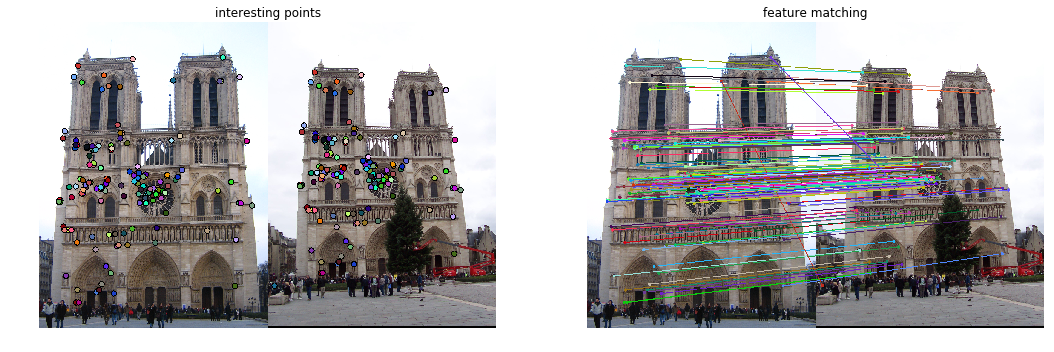

In [66]:
img1 = cv2.imread('vis_dots_result.png')
b,g,r = cv2.split(img1)
img1 = cv2.merge([r,g,b])
img2 = cv2.imread('vis_arrows_result.png')
b,g,r = cv2.split(img2)
img2 = cv2.merge([r,g,b])
plt.figure(figsize=(18, 12))
plt.subplot(1,2,1)
plt.title('interesting points')
plt.imshow(img1)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('feature matching')
plt.imshow(img2)
plt.axis('off')

plt.show()
